 January 2015 to December 2022 , Gold , Snp 500

In [2]:
import yfinance as yf
import pandas as pd
import statsmodels.api as sm

In [12]:
bitcoin = yf.download("BTC-USD", start="2015-01-01", end="2022-12-31")['Adj Close']
bitcoin = bitcoin.reset_index().rename(columns={'Date': 'date', 'Adj Close': 'bitcoin'})



[*********************100%***********************]  1 of 1 completed


In [14]:
# Function to fetch S&P 500 data
sp500 = yf.download("^GSPC", start="2015-01-01", end="2022-12-31")['Adj Close']
sp500 = sp500.reset_index().rename(columns={'Date': 'date', 'Adj Close': 'sp500'})
sp500



[*********************100%***********************]  1 of 1 completed


Ticker,date,^GSPC
0,2015-01-02 00:00:00+00:00,2058.199951
1,2015-01-05 00:00:00+00:00,2020.579956
2,2015-01-06 00:00:00+00:00,2002.609985
3,2015-01-07 00:00:00+00:00,2025.900024
4,2015-01-08 00:00:00+00:00,2062.139893
...,...,...
2009,2022-12-23 00:00:00+00:00,3844.820068
2010,2022-12-27 00:00:00+00:00,3829.250000
2011,2022-12-28 00:00:00+00:00,3783.219971
2012,2022-12-29 00:00:00+00:00,3849.280029


In [15]:
# Function to fetch Gold prices

gold = yf.download("GC=F", start="2015-01-01", end="2022-12-31")['Adj Close']
gold = gold.reset_index().rename(columns={'Date': 'date', 'Adj Close': 'gold'})
gold


[*********************100%***********************]  1 of 1 completed


Ticker,date,GC=F
0,2015-01-02 00:00:00+00:00,1186.000000
1,2015-01-05 00:00:00+00:00,1203.900024
2,2015-01-06 00:00:00+00:00,1219.300049
3,2015-01-07 00:00:00+00:00,1210.599976
4,2015-01-08 00:00:00+00:00,1208.400024
...,...,...
2006,2022-12-23 00:00:00+00:00,1795.900024
2007,2022-12-27 00:00:00+00:00,1814.800049
2008,2022-12-28 00:00:00+00:00,1807.900024
2009,2022-12-29 00:00:00+00:00,1819.500000


In [18]:
df = pd.merge(pd.merge(bitcoin, sp500, on='date', how='outer'), gold, on='date', how='outer')
df['^GSPC'] = df['^GSPC'].interpolate(method='linear')
df['GC=F'] = df['GC=F'].interpolate(method='linear')
df['date'] = pd.to_datetime(df['date']).dt.date
df.replace([float('inf'), float('-inf')], pd.NA, inplace=True)
df.dropna()

df = df.dropna()
print(df.isna().sum())
df.to_excel("/Users/nilaysinghsolanki/Downloads/data_actual.xlsx")

Ticker
date       0
BTC-USD    0
^GSPC      0
GC=F       0
dtype: int64


In [145]:
X = df[['BTC-USD', 'GC=F']]
y = df['^GSPC']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  ^GSPC   R-squared:                       0.905
Model:                            OLS   Adj. R-squared:                  0.904
Method:                 Least Squares   F-statistic:                 1.382e+04
Date:                Thu, 12 Dec 2024   Prob (F-statistic):               0.00
Time:                        16:13:55   Log-Likelihood:                -20276.
No. Observations:                2920   AIC:                         4.056e+04
Df Residuals:                    2917   BIC:                         4.058e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        568.0354     34.301     16.560      0.0

In [30]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import f  # Import the F-distribution from scipy.stats

# Load your data
data = pd.read_excel("/Users/nilaysinghsolanki/Downloads/data_actual.xlsx")

# Define the break point (adjust based on your dataset's timeline or split criteria)
break_point = int(len(data) * 0.1)  # Splits data into two halves

# Sub-sample the data
data1 = data.iloc[:break_point]
data2 = data.iloc[break_point:]

# Define the dependent and independent variables
y = data['^GSPC']
X = data[['BTC-USD', 'GC=F']]
X = sm.add_constant(X)  # Add constant for the intercept

# Full-sample regression
model_full = sm.OLS(y, X).fit()

# Sub-sample regressions
y1 = data1['^GSPC']
X1 = data1[['BTC-USD', 'GC=F']]
X1 = sm.add_constant(X1)

y2 = data2['^GSPC']
X2 = data2[['BTC-USD', 'GC=F']]
X2 = sm.add_constant(X2)

model1 = sm.OLS(y1, X1).fit()
model2 = sm.OLS(y2, X2).fit()

# Extract RSS (Residual Sum of Squares) for the models
rss_full = sum(model_full.resid ** 2)
rss1 = sum(model1.resid ** 2)
rss2 = sum(model2.resid ** 2)

# Number of observations and parameters
n_full = len(data)
n1 = len(data1)
n2 = len(data2)
k = X.shape[1]  # Number of parameters including intercept

# Chow Test Statistic
numerator = (rss_full - (rss1 + rss2)) / k
denominator = (rss1 + rss2) / (n1 + n2 - 2 * k)
chow_stat = numerator / denominator

# P-value calculation using scipy.stats F-distribution
p_value = 1 - f.cdf(chow_stat, k, (n1 + n2 - 2 * k))

# Output results
print("Chow Test Statistic:", chow_stat)
print("P-value:", p_value)

if p_value < 0.05:
    print("Reject the null hypothesis: Evidence of structural break")
else:
    print("Fail to reject the null hypothesis: No structural break detected")


Chow Test Statistic: 63.68444314884517
P-value: 1.1102230246251565e-16
Reject the null hypothesis: Evidence of structural break


In [24]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset

# Load your data (adjust the file path and column names as needed)
data = pd.read_excel("/Users/nilaysinghsolanki/Downloads/data_actual.xlsx")

# Define dependent and independent variables
y = data['^GSPC']  # Replace with the actual name of your dependent variable
X = data[['BTC-USD', 'GC=F']]  # Replace with the actual names of your predictors
X = sm.add_constant(X)  # Add constant for the intercept

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Perform Ramsey RESET Test
reset_test = linear_reset(model, power=2)  # Using power=2 for quadratic terms

# Display results
print("Ramsey RESET Test Statistic:", reset_test.statistic)
print("P-value:", reset_test.pvalue)

if reset_test.pvalue < 0.05:
    print("Reject the null hypothesis: Model has misspecification")
else:
    print("Fail to reject the null hypothesis: No evidence of misspecification")


Ramsey RESET Test Statistic: 922.3387069159267
P-value: 1.3668467413479641e-202
Reject the null hypothesis: Model has misspecification


In [31]:
import statsmodels.api as sm

# Assuming 'model' is the fitted OLS regression model
# Example:
# y = data['^GSPC']
# X = data[['BTC-USD', 'GC=F']]
# X = sm.add_constant(X)
# model = sm.OLS(y, X).fit()

# Perform Durbin-Watson test
dw_statistic = sm.stats.durbin_watson(model.resid)

# Output the result
print("Durbin-Watson Statistic:", dw_statistic)

# Interpretation guidelines:
# ~2.0 indicates no autocorrelation
# <2.0 indicates positive autocorrelation
# >2.0 indicates negative autocorrelation


Durbin-Watson Statistic: 0.01871882959747613


In [32]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan

# Assuming 'model' is the fitted OLS regression model
# Example:
# y = data['^GSPC']
# X = data[['BTC-USD', 'GC=F']]
# X = sm.add_constant(X)
# model = sm.OLS(y, X).fit()

# Perform Breusch-Pagan Test
bp_test = het_breuschpagan(model.resid, model.model.exog)

# Extract test results
lm_stat = bp_test[0]  # Lagrange Multiplier statistic
lm_pvalue = bp_test[1]  # p-value for LM test
f_stat = bp_test[2]  # F-statistic
f_pvalue = bp_test[3]  # p-value for F-test

# Output results
print("Breusch-Pagan Test Results:")
print(f"Lagrange Multiplier Statistic: {lm_stat}")
print(f"P-value (LM Test): {lm_pvalue}")
print(f"F-Statistic: {f_stat}")
print(f"P-value (F Test): {f_pvalue}")

# Interpretation:
# If the p-value < 0.05, reject the null hypothesis (homoskedasticity).
# This indicates the presence of heteroskedasticity.


Breusch-Pagan Test Results:
Lagrange Multiplier Statistic: 189.31409277837952
P-value (LM Test): 7.779775770948825e-42
F-Statistic: 101.11547563454626
P-value (F Test): 3.479021047843071e-43


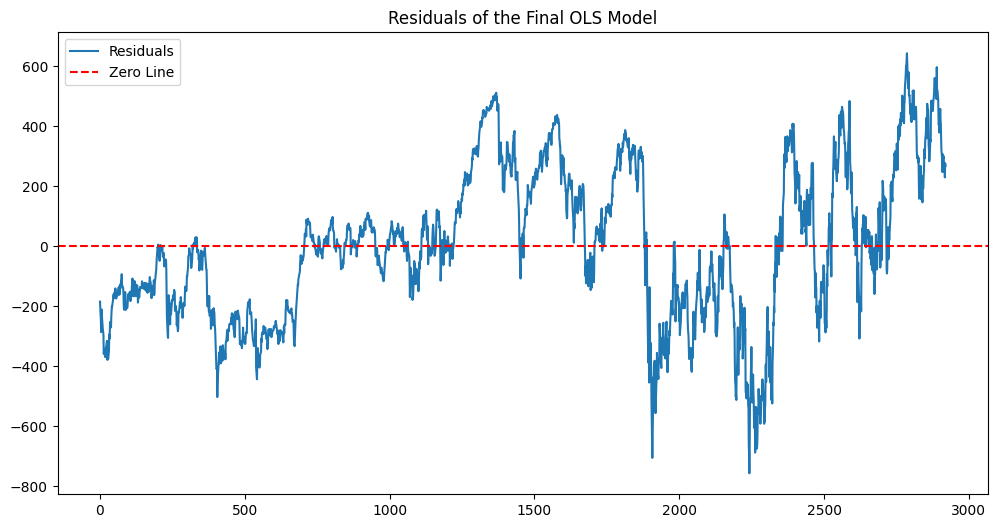

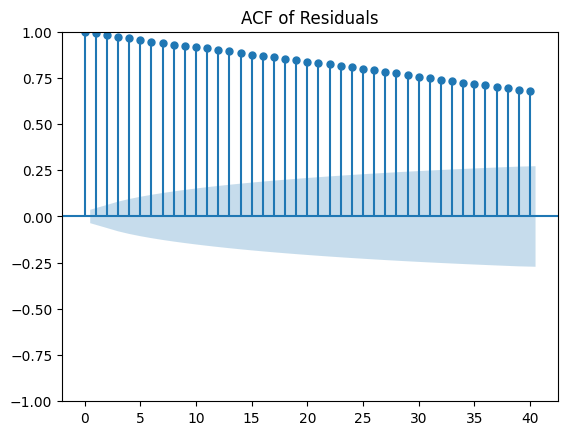

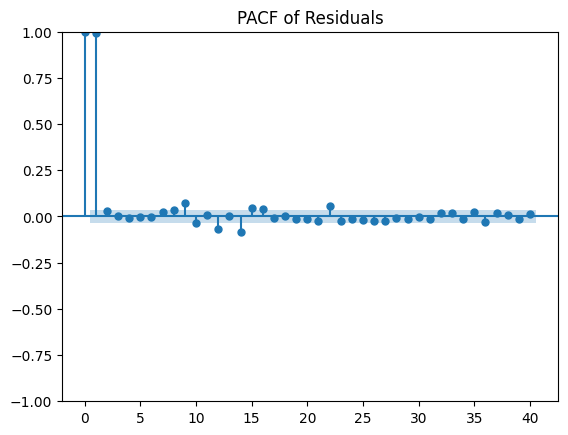

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2920
Model:                 ARIMA(1, 0, 1)   Log Likelihood              -14461.831
Date:                Fri, 13 Dec 2024   AIC                          28931.662
Time:                        23:49:05   BIC                          28955.579
Sample:                             0   HQIC                         28940.277
                               - 2920                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0009     70.358   1.27e-05      1.000    -137.899     137.901
ar.L1          0.9912      0.002    430.544      0.000       0.987       0.996
ma.L1         -0.0306      0.012     -2.530      0.0

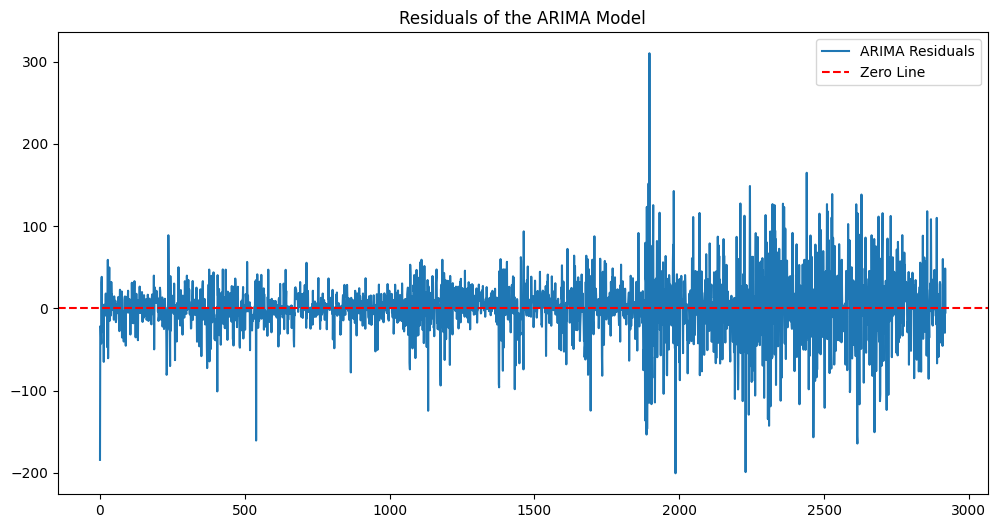

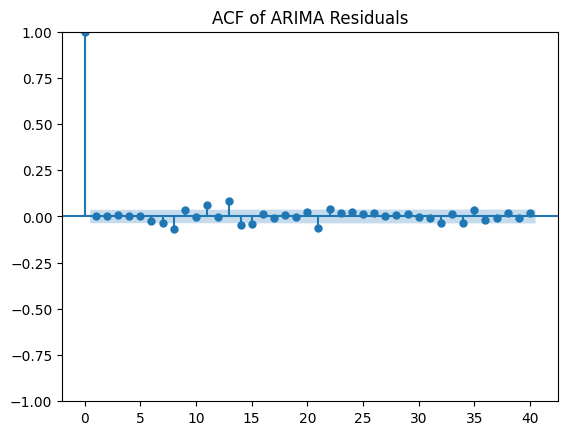

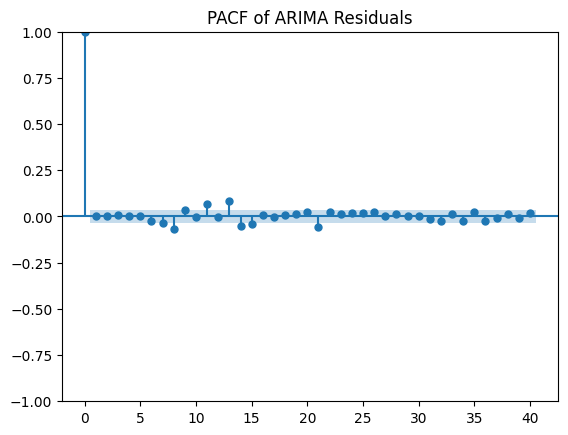

In [33]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Assuming 'model' is the final fitted OLS regression model
residuals = model.resid

# Step 1: Plot residuals
plt.figure(figsize=(12, 6))
plt.plot(residuals, label="Residuals")
plt.axhline(y=0, color="red", linestyle="--", label="Zero Line")
plt.title("Residuals of the Final OLS Model")
plt.legend()
plt.show()

# Step 2: Plot ACF and PACF
plot_acf(residuals, lags=40, title="ACF of Residuals")
plt.show()

plot_pacf(residuals, lags=40, title="PACF of Residuals")
plt.show()

# Step 3: Fit ARIMA model to residuals
# Identify order (p, d, q) based on ACF and PACF plots or use grid search for best parameters
arima_order = (1, 0, 1)  # Example: ARIMA(1, 0, 1)
arima_model = ARIMA(residuals, order=arima_order).fit()

# Step 4: Summary of ARIMA model
print(arima_model.summary())

# Step 5: Check residuals of the ARIMA model
# These should ideally have no significant autocorrelation
arima_residuals = arima_model.resid

# Plot ARIMA residuals
plt.figure(figsize=(12, 6))
plt.plot(arima_residuals, label="ARIMA Residuals")
plt.axhline(y=0, color="red", linestyle="--", label="Zero Line")
plt.title("Residuals of the ARIMA Model")
plt.legend()
plt.show()

# ACF and PACF of ARIMA residuals
plot_acf(arima_residuals, lags=40, title="ACF of ARIMA Residuals")
plt.show()

plot_pacf(arima_residuals, lags=40, title="PACF of ARIMA Residuals")
plt.show()


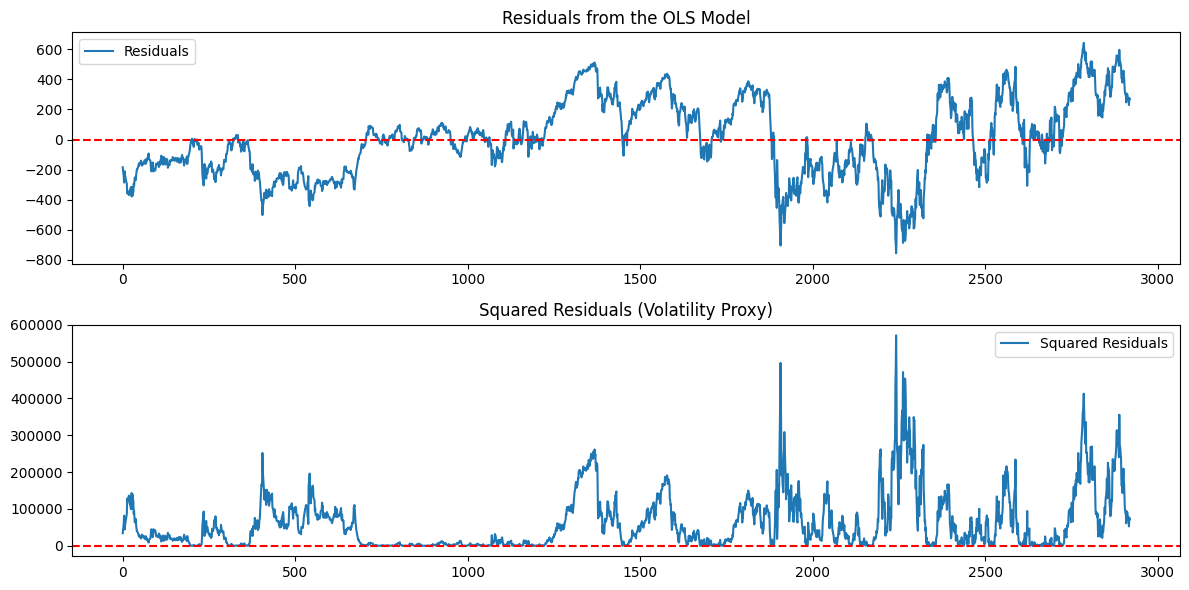

Iteration:      1,   Func. Count:      6,   Neg. LLF: 86114.07656192241
Iteration:      2,   Func. Count:     12,   Neg. LLF: 18824.630556858003
Iteration:      3,   Func. Count:     17,   Neg. LLF: 18829.128352358304
Iteration:      4,   Func. Count:     23,   Neg. LLF: 18820.822846968178
Iteration:      5,   Func. Count:     28,   Neg. LLF: 18820.778844474353
Iteration:      6,   Func. Count:     33,   Neg. LLF: 18820.770995750037
Iteration:      7,   Func. Count:     38,   Neg. LLF: 18820.743884438765
Iteration:      8,   Func. Count:     43,   Neg. LLF: 18820.73736971439
Iteration:      9,   Func. Count:     48,   Neg. LLF: 18820.734262073245
Iteration:     10,   Func. Count:     53,   Neg. LLF: 18820.71617723065
Iteration:     11,   Func. Count:     58,   Neg. LLF: 18820.676358127486
Iteration:     12,   Func. Count:     63,   Neg. LLF: 18820.569075892992
Iteration:     13,   Func. Count:     68,   Neg. LLF: 18820.31141605902
Iteration:     14,   Func. Count:     73,   Neg. LLF: 1

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 6.292e+04. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 0.1 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


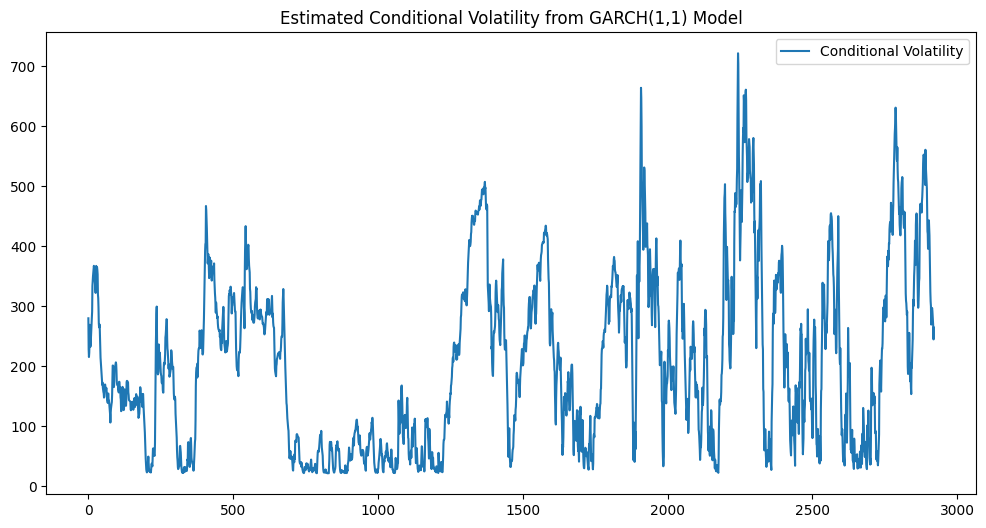

<Figure size 1200x600 with 0 Axes>

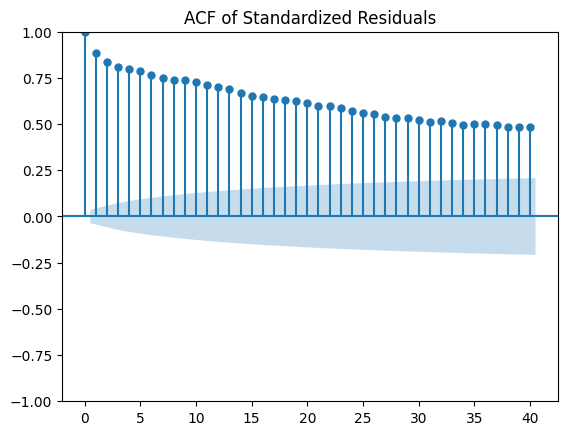

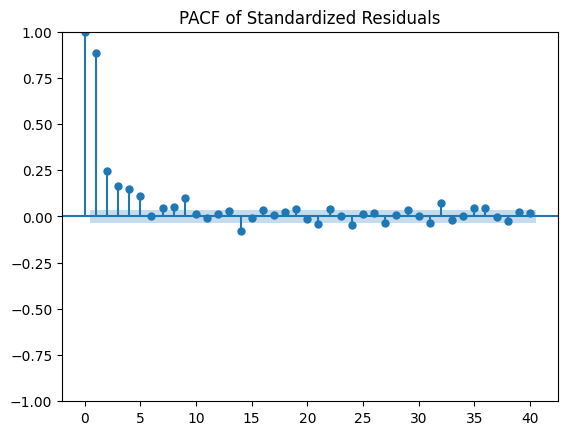

ARCH Test Results:
Lagrange Multiplier Statistic: 0.4458315148491365
P-value (LM Test): 0.9999961887848831
F-Statistic: 0.04442142976910321
P-value (F Test): 0.999996231349139


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

# Assuming 'model' is the final fitted OLS regression model
residuals = model.resid

# Step 1: Plot residuals and squared residuals
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(residuals, label="Residuals")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residuals from the OLS Model")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(residuals ** 2, label="Squared Residuals")
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Squared Residuals (Volatility Proxy)")
plt.legend()
plt.tight_layout()
plt.show()

# Step 2: Fit a GARCH model
# Fit a GARCH(1,1) model to the residuals
garch_model = arch_model(residuals, vol='Garch', p=1, q=1, dist='normal')
garch_results = garch_model.fit()

# Step 3: Print GARCH model summary
print(garch_results.summary())

# Step 4: Plot the conditional volatility
plt.figure(figsize=(12, 6))
plt.plot(garch_results.conditional_volatility, label="Conditional Volatility")
plt.title("Estimated Conditional Volatility from GARCH(1,1) Model")
plt.legend()
plt.show()

# Step 5: Check standardized residuals
standardized_residuals = garch_results.resid / garch_results.conditional_volatility

# ACF of standardized residuals
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))
plot_acf(standardized_residuals, lags=40, title="ACF of Standardized Residuals")
plt.show()

plot_pacf(standardized_residuals, lags=40, title="PACF of Standardized Residuals")
plt.show()

# Step 6: Check for remaining heteroskedasticity
from statsmodels.stats.diagnostic import het_arch

lm_stat, lm_pvalue, f_stat, f_pvalue = het_arch(standardized_residuals ** 2)
print("ARCH Test Results:")
print(f"Lagrange Multiplier Statistic: {lm_stat}")
print(f"P-value (LM Test): {lm_pvalue}")
print(f"F-Statistic: {f_stat}")
print(f"P-value (F Test): {f_pvalue}")

# Interpretation of ARCH Test:
# If p-value < 0.05, reject the null hypothesis of no ARCH effect.
